# Summary Task 6 (Analisis Lokasi Logistik Darurat Bencana Gempa Bumi)

Penentuan Skor Setiap Variabel

- Demografi (Populasi tinggi = 3) → agar posko menjangkau lebih banyak orang.
- Jalan utama (akses tinggi = 3) → memudahkan distribusi logistik.
- Sumber makanan (intensitas minimarket/pasar tinggi = 3) → mendukung ketersediaan suplai.
- Intensitas gempa (rendah = 3, tinggi = 1) → lokasi aman secara geologi.

by Rofiatul Mutmainah 

In [ ]:
#Import library 
import os 
import geopandas as gpd 
import requests
import pandas as pd
import folium 
import matplotlib.pyplot as plt


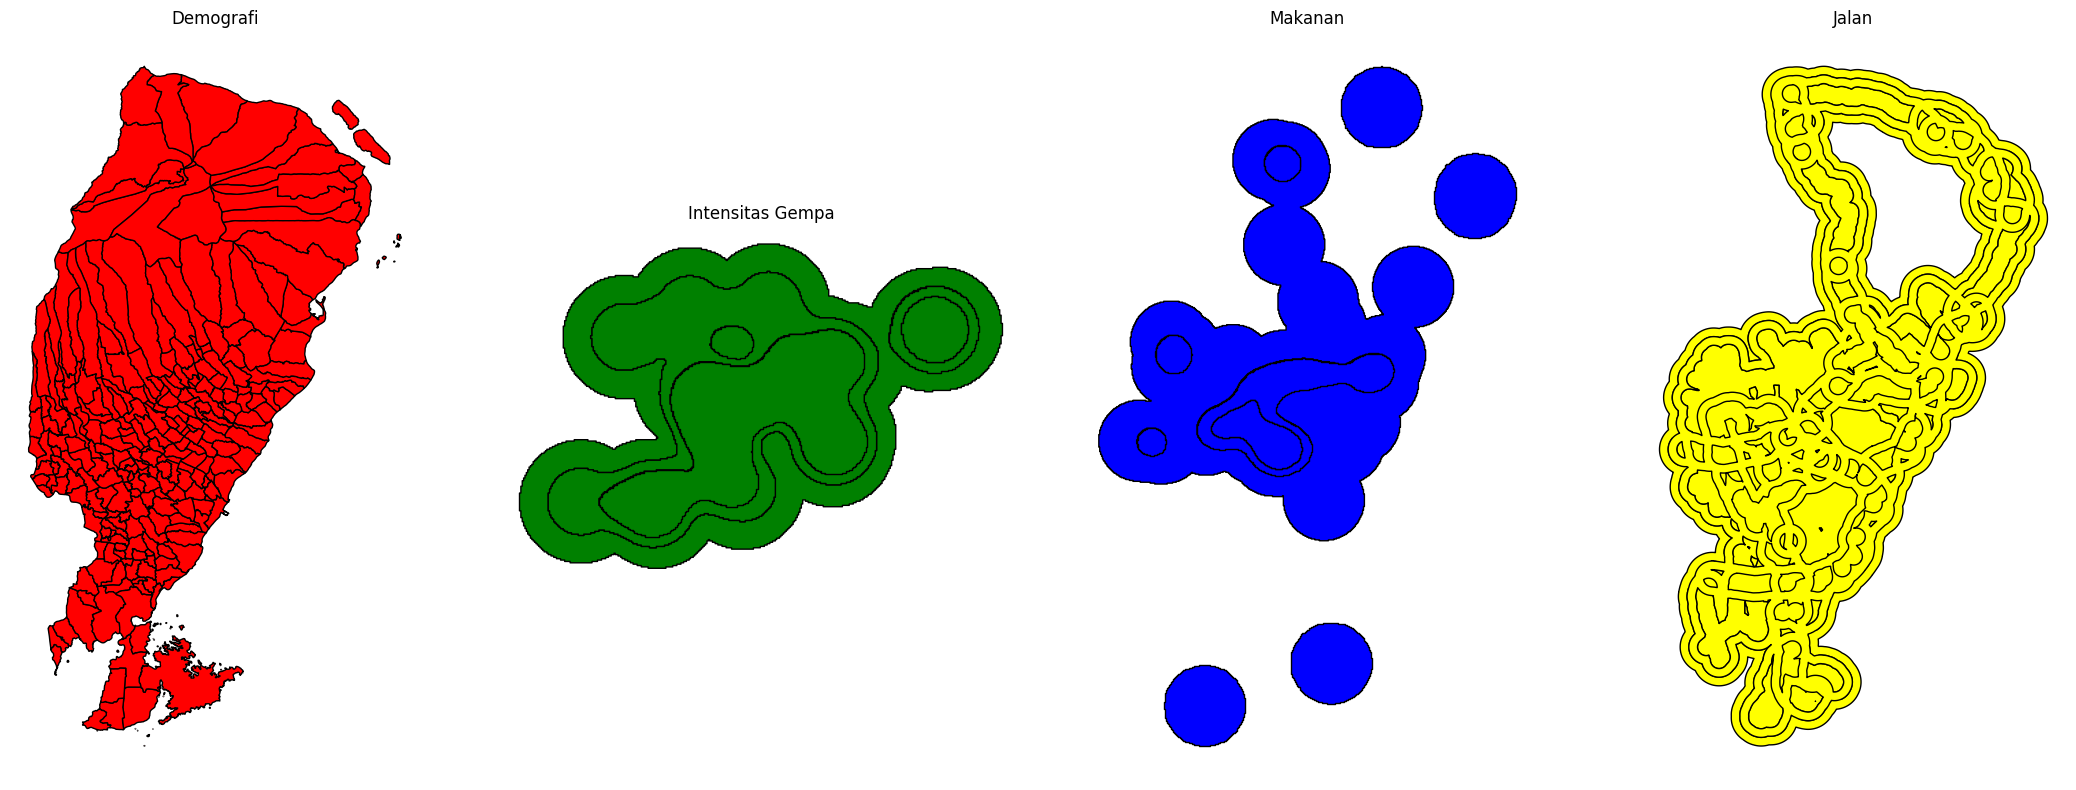

In [3]:
urls = {
    "Intensitas Gempa" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d394dc425f0e41008a52ef3923d68925&layer_id=68aeb363278efb81183b8e1b&project_id=68ae8ee1f4c6b405edd808e4&limit=10000", 
    "Makanan" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d394dc425f0e41008a52ef3923d68925&layer_id=68aeecb2bdbfd0f39b00f188&project_id=68ae8ee1f4c6b405edd808e4&limit=10000", 
   "Demografi" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d394dc425f0e41008a52ef3923d68925&layer_id=68aeeca1ef2411f2c7b69c95&project_id=68ae8ee1f4c6b405edd808e4&limit=10000", 
  "Jalan" : "https://geoserver.mapid.io/layers_new/get_layer?api_key=d394dc425f0e41008a52ef3923d68925&layer_id=68aeec98278efb81183bc580&project_id=68ae8ee1f4c6b405edd808e4&limit=10000"}

# Mengambil data API
def get_data(url, layer_name):
    response = requests.get(url)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        # Menambahkan kolom skor ke setiap data API
        if layer_name == "Demografi":
            gdf["SKOR_DEMOGRAFI"] = gdf.get("KELAS", "").str.upper().map({"RENDAH": 1, "SEDANG":2, "TINGGI":3}).fillna(0)
        elif layer_name == "Intensitas Gempa":
            gdf["SKOR_GEMPA"] = gdf.get("KELAS_GEMPA", "").str.upper().map({"RENDAH": 3, "SEDANG":2, "TINGGI":1}).fillna(0)
        elif layer_name == "Makanan":
            gdf["SKOR_SUPLAY"] = gdf.get("SUPLAY", "").str.upper().map({"RENDAH": 1, "SEDANG":2, "TINGGI":3}).fillna(0)
        elif layer_name == "Jalan":
            gdf["SKOR_AKSES"] = gdf.get("AKSES", "").str.upper().map({"RENDAH": 1, "SEDANG":2, "TINGGI":3}).fillna(0)

        return gdf
    return gpd.GeoDataFrame()

# Ambil data untuk semua layer
gdf_demografi = get_data(urls["Demografi"], "Demografi")
gdf_gempa = get_data(urls["Intensitas Gempa"], "Intensitas Gempa") 
gdf_makanan = get_data(urls["Makanan"], "Makanan")
gdf_jalan = get_data(urls["Jalan"], "Jalan")

# Visualisasi data variabel menggunakan Matplotlib
def visualize_data(gdfs):
    fig, axes = plt.subplots(1, len(gdfs), figsize=(22,8))
    color_map = ['red', 'green', 'blue','yellow']
    for ax, (name, gdf), color in zip(axes, gdfs.items(), color_map):
        gdf.plot(ax=ax, color=color, edgecolor='black')
        ax.set_title(name)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Menambahkan Visual dari ketiga variabel 
visualize_data({"Demografi" : gdf_demografi, "Intensitas Gempa" : gdf_gempa, "Makanan" : gdf_makanan, "Jalan" : gdf_jalan})

In [8]:
#Perbaikan/handling NULL dalam data 

gdf_demografi['SKOR_DEMOGRAFI'] = gdf_demografi['SKOR_DEMOGRAFI'].fillna(0)
gdf_gempa['SKOR_GEMPA'] = gdf_gempa['SKOR_GEMPA'].fillna(0)
gdf_makanan['SKOR_SUPLAY'] = gdf_makanan['SKOR_SUPLAY'].fillna(0)
gdf_jalan['SKOR_AKSES'] = gdf_jalan['SKOR_AKSES'].fillna(0)


#Analisis Intersection/Overlay

intersection_gdf = gdf_demografi
if not gdf_gempa.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_gempa, how='intersection', keep_geom_type=False)
if not gdf_makanan.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_makanan, how='intersection', keep_geom_type=False)
if not gdf_jalan.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_jalan, how='intersection', keep_geom_type=False)

# Memperbaiki geometri setelah intersection
intersection_gdf = intersection_gdf[intersection_gdf.is_valid]  # Menghapus geometri yang tidak valid
intersection_gdf['geometry'] = intersection_gdf['geometry'].apply(lambda x: x.make_valid() if not x.is_valid else x)

# Perbaiki nilai NULL setelah intersection
intersection_gdf['SKOR_DEMOGRAFI'] = intersection_gdf['SKOR_DEMOGRAFI'].fillna(0)
intersection_gdf['SKOR_GEMPA'] = intersection_gdf['SKOR_GEMPA'].fillna(0)
intersection_gdf['SKOR_SUPLAY'] = intersection_gdf['SKOR_SUPLAY'].fillna(0)
intersection_gdf['SKOR_AKSES'] = intersection_gdf['SKOR_AKSES'].fillna(0)

# Hitung penjumlahan kolom skor
intersection_gdf['SKOR_TOTAL'] = intersection_gdf['SKOR_DEMOGRAFI'] + intersection_gdf['SKOR_GEMPA'] + intersection_gdf['SKOR_SUPLAY'] + intersection_gdf['SKOR_AKSES']

# Klasifikasi
intersection_gdf['KESESUAIAN'] = pd.cut(
    intersection_gdf['SKOR_TOTAL'], 
    bins=[3, 7, 10, 12], # Rentang/Interval Skor
    labels=['RENDAH', 'SEDANG', 'TINGGI'],
    include_lowest=True
)

print(intersection_gdf[['SKOR_DEMOGRAFI', 'SKOR_GEMPA', 'SKOR_SUPLAY', 'SKOR_AKSES', 'SKOR_TOTAL', 'KESESUAIAN']].head(10))

   SKOR_DEMOGRAFI  SKOR_GEMPA  SKOR_SUPLAY  SKOR_AKSES  SKOR_TOTAL KESESUAIAN
0               2           2            1           1           6     RENDAH
1               2           2            1           2           7     RENDAH
2               2           1            1           1           5     RENDAH
3               2           1            1           1           5     RENDAH
4               2           1            1           2           6     RENDAH
5               1           3            1           1           6     RENDAH
6               1           3            1           2           7     RENDAH
7               1           3            2           3           9     SEDANG
8               1           3            2           2           8     SEDANG
9               1           2            2           3           8     SEDANG


In [9]:
#Simpan ke json

import os

output_dir = r"E:\Belajar\MAPID WebGIS Bootcamp\22-08-2025 Sesi 6\Task"
os.makedirs (output_dir, exist_ok=True)

#Ambil data multipolygon dan polygon 
intersection_gdf_polygon = intersection_gdf[intersection_gdf.geometry.type.isin(['polygon', 'MultiPolygon'])]

#Memperbaiki geometry
intersection_gdf_polygon['geometry'] = intersection_gdf_polygon['geometry'].apply(lambda x: x.make_valid()if not x.is_valid else x)

#simpan data json 
intersection_gdf_polygon.to_file(os.path.join(output_dir, "Hasil_intersect.json"), driver='GeoJSON')

print(f"Data Berhasil Disimpan di: {output_dir}")

c:\Users\user\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Python 3.13\WEBGIS_ACADEMY\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\user\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Python 3.13\WEBGIS_ACADEMY\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Data Berhasil Disimpan di: E:\Belajar\MAPID WebGIS Bootcamp\22-08-2025 Sesi 6\Task
